<h1 style="text-align:center;">RL pentru algoritmi de publicitate online</h1>

In [10]:
# librariile necesare
import numpy as np
import gymnasium as gym
from gymnasium import spaces, Env
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Mediul `AdEnvironment`

Acest mediu incearca sa simuleze interactiunile dintre utilizatori si reclame:

- **Useri**: definiti prin caracteristici (ex. interese, varsta etc.).
- **Reclame**: au categorii care le fac mai mult sau mai putin relevante
- **Feedback**: recompensa este calculata pe baza similaritatii dintre utilizator si reclama

In [11]:
# clasa pentru mediul personalizat
class AdEnvironment(Env):
    def __init__(self):
        super(AdEnvironment, self).__init__()
        self.num_ads = 5                                                                        # nr reclame
        self.num_users = 10                                                                     # nr useri
        self.users = np.random.rand(self.num_users, 3)                                          # set de useri, definit de 3 caracteristici
        self.ads = np.random.rand(self.num_ads, 3)                                              # set de reclame, definit de 3 caracteristici
        self.action_space = spaces.Discrete(self.num_ads)                                       # agentul are de ales intre cele 5 reclame
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)        # observatiile sunt caracteristicile userului


    # functia reset, folosita pentru reinitializarea mediului si de a returna observatia initiala
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_user = np.random.randint(0, self.num_users)
        observation = self.users[self.current_user]
        # print(f"Reset: observation={observation}")
        return observation, {}

    # functia step defineste ce se intampla in fiecare pas 
    def step(self, action):
        user = self.users[self.current_user]
        ad = self.ads[action]
        reward = np.dot(user, ad)
        done = True
        truncated = False
        info = {}
        return self.users[self.current_user], reward, done, truncated, info



# testare env
env = AdEnvironment()
obs, info = env.reset() 

action = env.action_space.sample()                                              
obs, reward, done, truncated, info = env.step(action)

print(f"Observation: {obs}\n"
      f"Action: {action}\n"
      f"Reward: {round(reward, 3)}\n"
      f"Done: {done}")

Observation: [0.3345578  0.82249363 0.18043462]
Action: 2
Reward: 0.897
Done: True


## 1. Antrenarea modelului DQN (Deep-Q-Network)

Vom utiliza biblioteca `Stable-Baselines3` pentru a antrena un model DQN pe mediul `AdEnvironment`. Modelul invata sa maximizeze recompensa acumulata.

In [12]:
# vectorizarea mediului
env = make_vec_env(lambda: AdEnvironment(), n_envs=1)

# configurarea modelului DQN
model = DQN("MlpPolicy", env, verbose=1)

# antrenarea modelului pentru 10000 de pasi
model.learn(total_timesteps=10000)

# il salvam
model.save("dqn_ad_model")
print("Your model has been trained and saved successfully")



Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.353    |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3816     |
|    time_elapsed     | 0        |
|    total_timesteps  | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.603    |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4324     |
|    time_elapsed     | 0        |
|    total_timesteps  | 8        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.542    |
|    exploration_rate | 0.989    |
| time/               |          |
|  

## Testarea modelului DQN

Dupa antrenare, evaluam modelul pe mai multe episoade pentru a calcula performanta medie.

In [13]:
model = DQN.load("dqn_ad_model")
env = AdEnvironment()

# testare
total_rewards = []
for _ in range(100):                                              # 100 episoade de test
    obs, info = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_rewards.append(reward)

# recompensa medie
avg_reward = sum(total_rewards) / len(total_rewards)
print(f"Average reward per episode using DQN: {round(avg_reward, 3)}")

Average reward per episode using DQN: 1.162


## Vizualizarea performantei DQN

Evolutia recompensei medii pe parcursul episoadelor

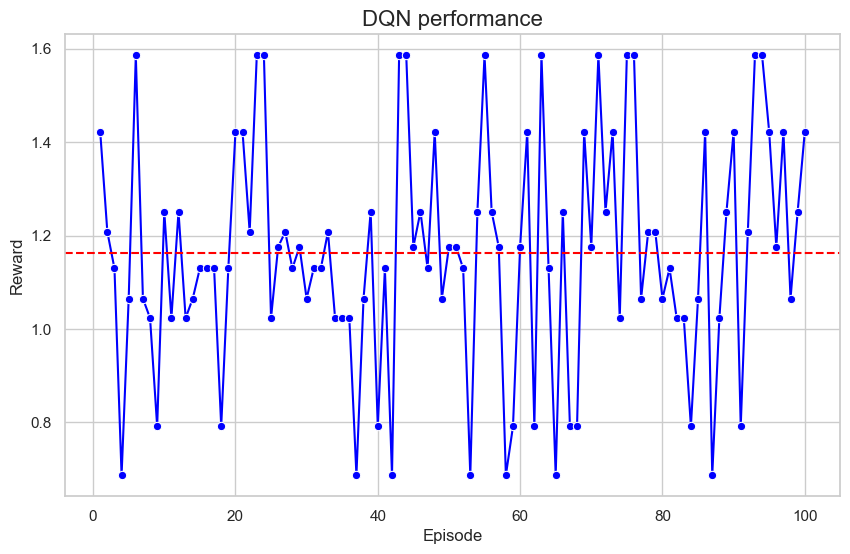

In [14]:
rewards = total_rewards[:100] 
avg_reward = sum(rewards) / len(rewards)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(rewards) + 1), y=rewards, marker="o", color="blue")

plt.axhline(y=avg_reward, color='red', linestyle='--', label=f'Media Reward: {avg_reward:.2f}')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("DQN performance", fontsize=16)
plt.show()

## 2. Antrenarea modelului PPO (Proximal Policy Optimization)

In [15]:
# vectorizarea mediului
env = make_vec_env(lambda: AdEnvironment(), n_envs=1)

# configurarea modelului PPO
ppo_model = PPO("MlpPolicy", env, verbose=1)

# antrenarea modelului
ppo_model.learn(total_timesteps=10000)

# save
ppo_model.save("ppo_ad_model")
print("Your model has been trained and saved successfully")

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.662    |
| time/              |          |
|    fps             | 6541     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.754       |
| time/                   |             |
|    fps                  | 4443        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.050017573 |
|    clip_fraction        | 0.625       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | -0.0153     |
|    learning

## Testarea modelului PPO

In [16]:
# incarcarea modelului PPO
ppo_model = PPO.load("ppo_ad_model")
env = AdEnvironment()

# testare
ppo_rewards = []
for _ in range(100):
    obs, info = env.reset() 
    done = False
    while not done:
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)  
        ppo_rewards.append(reward)

# average reward
ppo_avg_reward = sum(ppo_rewards) / len(ppo_rewards)
print(f"Average reward per episode PPO: {round(ppo_avg_reward, 3)}")

Average reward per episode PPO: 0.859


## Vizualizarea performantei PPO

Evolutia recompensei medii pe parcursul episoadelor

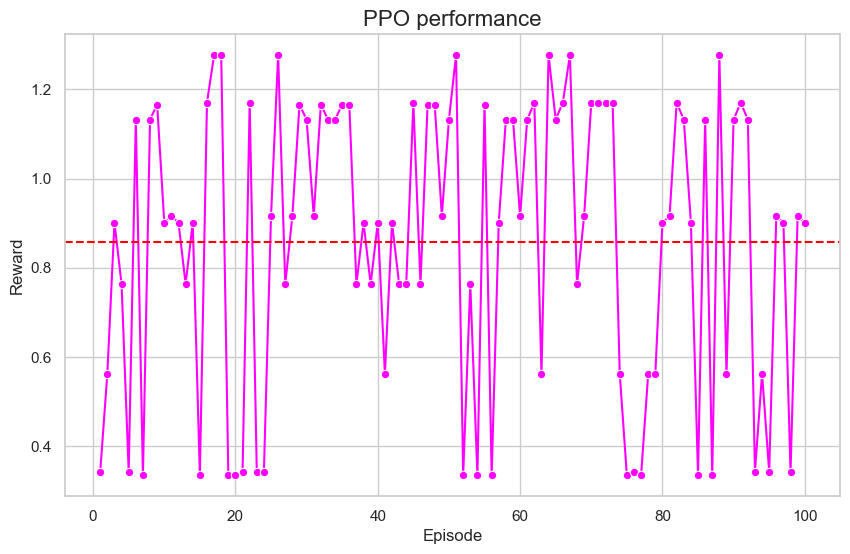

In [17]:
rewards = ppo_rewards[:100]
avg_reward = sum(rewards) / len(rewards)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(rewards) + 1), y=rewards, marker="o", color="fuchsia")

plt.axhline(y=avg_reward, color='red', linestyle='--', label=f'Media Reward: {avg_reward:.2f}')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("PPO performance", fontsize=16)
plt.show()

## Compararea performantei DQN vs PPO

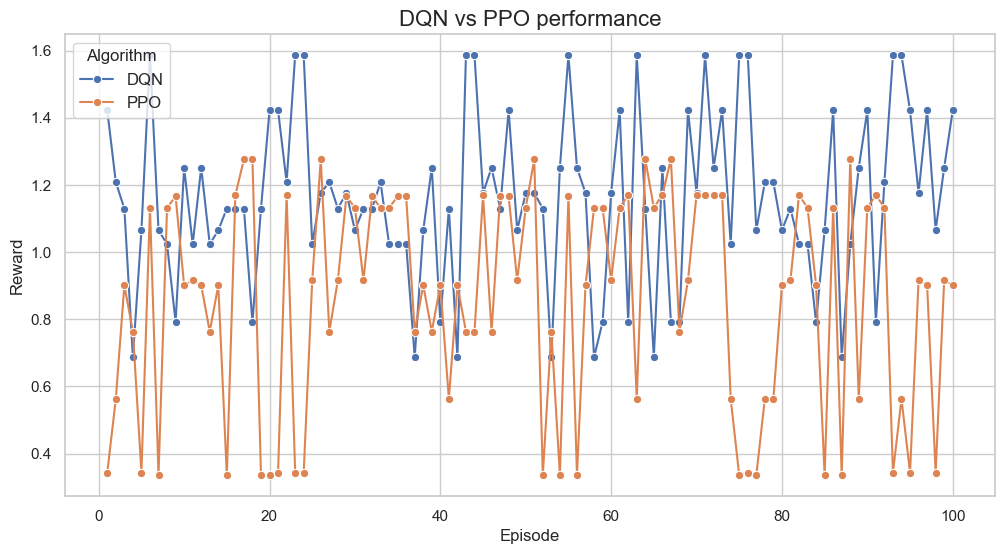

In [18]:
dqn_rewards = [float(reward) for reward in total_rewards[:100]]
ppo_rewards = [float(reward) for reward in ppo_rewards[:100]]

data = {
    "Episode": list(range(1, 101)) * 2,  
    "Reward": dqn_rewards + ppo_rewards,  
    "Algorithm": ["DQN"] * 100 + ["PPO"] * 100 
}

# dataframe pt seaborn
df = pd.DataFrame(data)

# plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Episode", y="Reward", hue="Algorithm", marker="o")


plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.title("DQN vs PPO performance", fontsize=16)
plt.legend(title="Algorithm", fontsize=12)
plt.show()